<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Курс "Глубокое обучение". Первый семестр</b></h3>

# Домашнее задание. Сегментация изображений

---


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>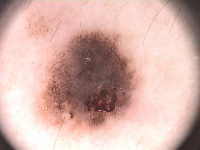</td><td>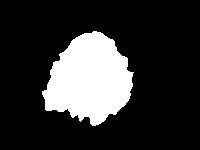</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [ ]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2021-02-03 11:51:42--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2021-02-03 11:51:43--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce20f62f6168a7510536e9720ae.dl.dropboxusercontent.com/cd/0/inline/BIMI0oDggn4QwXc9TOJ6yPb18ghESYBKVzZCaUOMTY7Wd7S2ZISCY3Q-Nn1Q3KPbt_ZSgKP33wO4JODv1K8Rhitj2Lhh8H-2HPmZfoxsdPIXUA/file# [following]
--2021-02-03 11:51:43--  https://uce20f62f6168a7510536e9720ae.dl.dropboxusercontent.com/cd/0/inline/BIMI0oDggn4QwXc9TOJ6yPb18ghESYBKVzZCaUOMTY7Wd7S2ZISCY3Q-Nn1Q3KPbt_ZSgKP33wO4JODv1K8Rhitj2Lhh8H-2HPmZfoxsdPIXUA/file
Resolving 

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

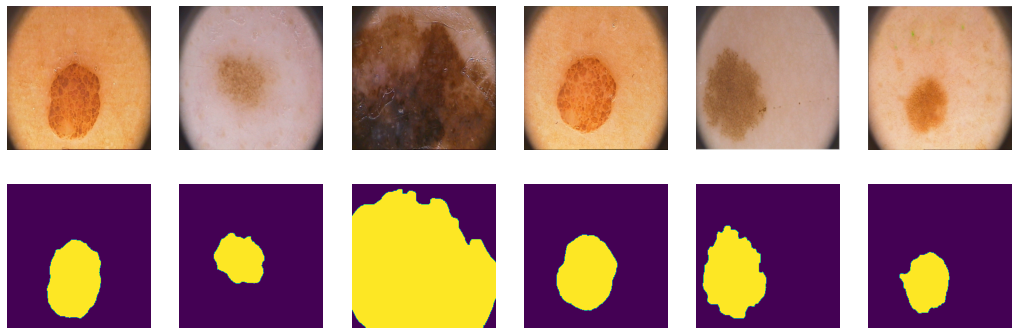

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 3
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
!nvidia-smi

Tue Dec 22 11:57:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

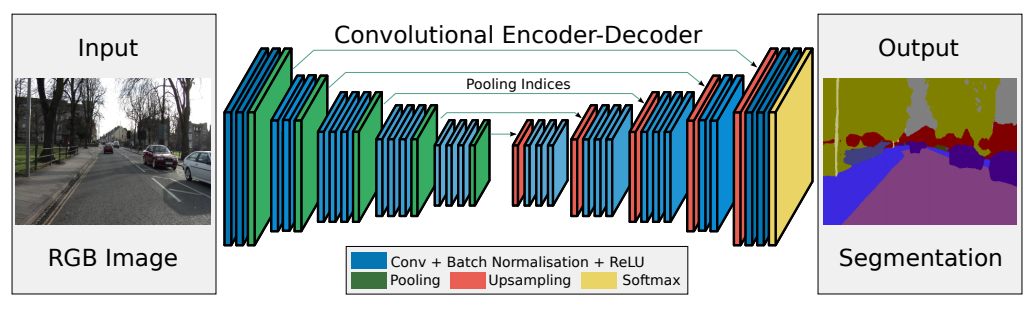

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(256), 
            nn.ReLU(), 
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(256), 
            nn.ReLU())
        self.pool0 = nn.MaxPool2d((2, 2), return_indices=True)   # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(128), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(128), 
            nn.ReLU())
        self.pool1 =  nn.MaxPool2d((2, 2), return_indices=True)  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU(), 
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU())
        self.pool2 =  nn.MaxPool2d((2, 2), return_indices=True)  # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(32), 
            nn.ReLU(), 
            nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(32), 
            nn.ReLU())
        self.pool3 =  nn.MaxPool2d((2, 2), return_indices=True)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=(1, 1), padding=0), 
            nn.BatchNorm2d(16), 
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(1, 1), padding=0), 
            nn.BatchNorm2d(32), 
            nn.ReLU())

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(32), 
            nn.ReLU(), 
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU())

        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU(), 
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(128), 
            nn.ReLU())

        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(128), 
            nn.ReLU(), 
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(256), 
            nn.ReLU())

        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(256), 
            nn.ReLU(), 
            nn.Conv2d(256, 1, kernel_size=(3, 3), padding=1))
        


    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0, idx0 = self.pool1(e0)
        e1 = self.enc_conv1(e0)
        e1, idx1 = self.pool1(e1)
        e2 = self.enc_conv2(e1)
        e2, idx2 = self.pool1(e2)
        e3 = self.enc_conv3(e2)
        e3, idx3 = self.pool1(e3)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, idx3))
        d1 = self.dec_conv1(self.upsample1(d0, idx2))
        d2 = self.dec_conv2(self.upsample2(d1, idx1))
        d3 = self.dec_conv3(self.upsample3(d2, idx0)) # no activation
        
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_pred, y_real):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    loss =  y_pred - y_real * y_pred + torch.log(1 + torch.exp( - y_pred))
    return torch.mean(loss)

In [ ]:
t1 = torch.randn(3, 1, 256, 256)
t2 = torch.randn(3, 1, 256, 256)
nn.BCEWithLogitsLoss()(t1, t2), bce_loss(t1, t2)

(tensor(0.8068), tensor(0.8068))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, device):
    X_val, Y_val = next(iter(data_val))
    sigmoig = nn.Sigmoid()
    train_loss = []
    val_loss = []


    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = sigmoig(model(X_batch))
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward() # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        train_loss.append(avg_loss)
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        X_val_cuda = X_val.to(device)
        Y_p = sigmoig(model(X_val_cuda)) 
        Y_hat = Y_p.cpu().detach().numpy()  # detach and put into cpu

        Y_for_loss = torch.Tensor(Y_hat)
        v_loss = loss_fn(Y_for_loss, Y_val)
        val_loss.append(v_loss)

        # Visualize tools
        clear_output(wait=True)
        for k in range(3):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    return train_loss, val_loss

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    sigma = nn.Sigmoid()
    Y_pred = [ model(sigma(X_batch)) for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    sigmoid = nn.Sigmoid()
    threshold = 0.5

    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)

        Y_pred = (sigmoid(model(X_batch)) > threshold).float()
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
model = SegNet().to(device)

In [ ]:
!nvidia-smi

Tue Dec 22 11:57:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W /  70W |    973MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

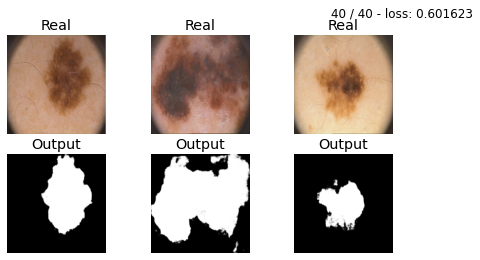

In [ ]:
max_epochs = 40
optim = torch.optim.Adam(model.parameters(), lr=0.00001)
train_bce, val_bce = train(model, optim, bce_loss, max_epochs, data_tr, data_val, device)

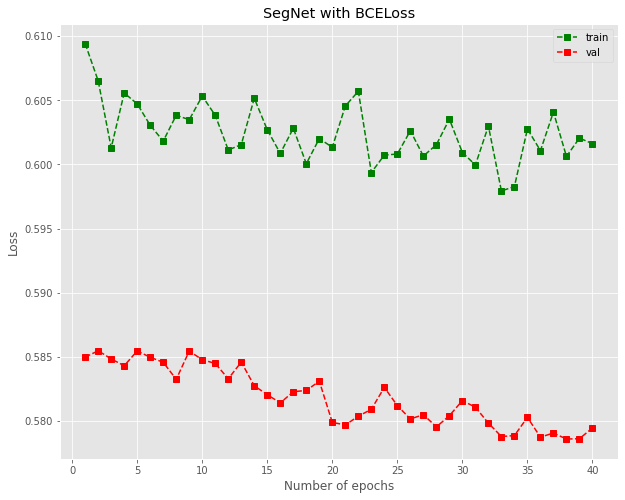

In [ ]:
plt.style.use('ggplot')

epochs = [*range(1,  max_epochs + 1)]
plt.figure(figsize=(10, 8))
plt.plot(epochs, train_bce, 's--g', label='train')
plt.plot(epochs, val_bce, 's--r', label='val')
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('SegNet with BCELoss')
None

In [ ]:
print('IOU score: %.3f' %(score_model(model, iou_pytorch, data_val)))

IOU score: 0.655


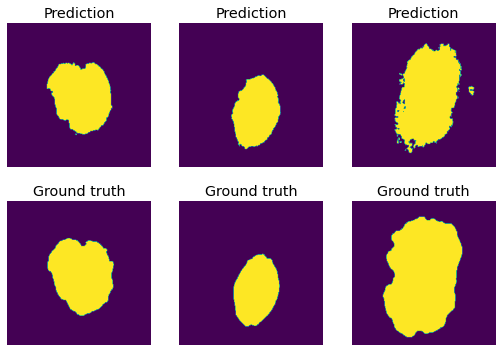

In [ ]:
x, y = next(iter(data_val))
y_hat = (model(x.to(device)) > 0.5).float()
y_h = y_hat.detach().cpu().numpy()

plt.figure(figsize=(18, 6))
for i in range(3):

    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.title('Prediction')
    plt.imshow(y_h[i, 0])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.title('Ground truth')
    plt.imshow(y[i, 0])
plt.show();

Ответьте себе на вопрос: не переобучается ли моя модель?

Где-то после 15-ой эпои модель начинает переобучаться. Это может быть связано с высоким lr, а также это можно отрегулировать с помощью функций потерь.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало, прежде чем бить тревогу попробуйте поперебирать различные варианты, убедитесь, что во всех других сетапах сетть достигает желанного результата. СПОЙЛЕР: учиться она будеет при всех лоссах предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникаемой в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred, eps = 1e-8):
    num = (y_real * y_pred).sum(dim=(2,3))
    den =  y_real.sum(dim=(2,3)) + y_pred.sum(dim=(2,3)) + eps
    res = 1 - (num / den).mean()
    return res 

In [ ]:
t1 = torch.randn(1, 1, 256, 256)
t2 = torch.randn(1, 1, 256, 256)
dice_loss(t1, t2)

tensor(1.0620)

Проводим тестирование:

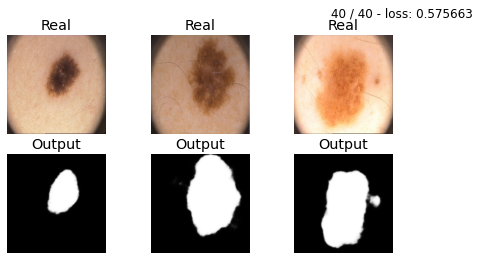

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(model_dice.parameters(), lr=0.00001)
train_dice, val_dice = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val, device)

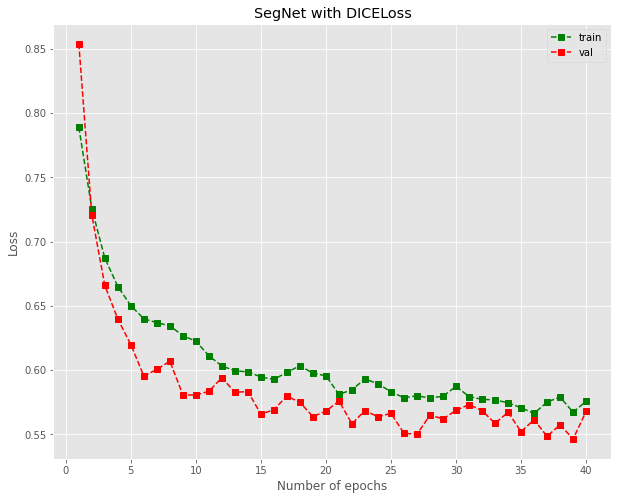

In [ ]:
plt.style.use('ggplot')

epochs = [*range(1,  max_epochs + 1)]
plt.figure(figsize=(10, 8))
plt.plot(epochs, train_dice, 's--g', label='train')
plt.plot(epochs, val_dice, 's--r', label='val')
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('SegNet with DICELoss')
None

In [ ]:
print("IOU score: %.3f" %(score_model(model_dice, iou_pytorch, data_val)))

IOU score: 0.687


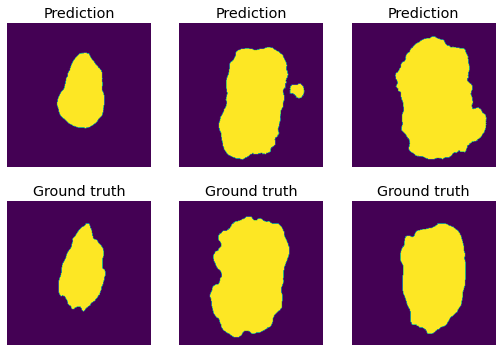

In [ ]:
x, y = next(iter(data_val))
y_hat = (model_dice(x.to(device))>0.5).float()
y_h = y_hat.detach().cpu().numpy()

plt.figure(figsize=(18, 6))
for i in range(3):
    plt.subplot(2, 6, i+1)
    plt.title('Prediction')
    plt.axis("off")
    plt.imshow(y_h[i, 0])

    plt.subplot(2, 6, i+7)
    plt.title('Ground truth')
    plt.axis("off")
    plt.imshow(y[i, 0])
plt.show();

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_pred, y_true, eps = 1e-8, gamma = 2):
    #y_pred =  # hint: torch.clamp
    sigma = nn.Sigmoid()(y_pred)

    your_loss = - (((1 - sigma)** gamma) * y_true * torch.log(sigma) + (1 - y_true) * torch.log(1 - sigma))
    return torch.mean(your_loss)

In [ ]:
y_real = torch.randn(3, 1, 256, 256) 
y_pred = torch.randn(3, 1, 256, 256) 
focal_loss(y_real, y_pred)

tensor(0.8097)

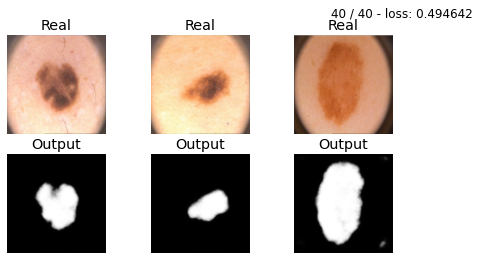

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(model_focal.parameters(), lr=0.00001)
train_focal, val_focal  = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val, device)

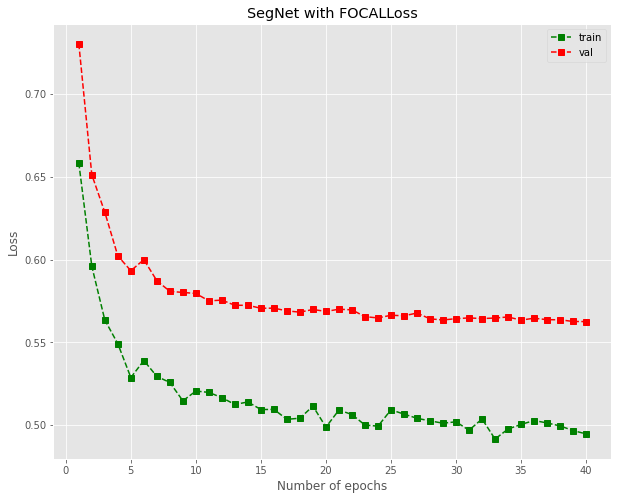

In [ ]:
plt.style.use('ggplot')

epochs = [*range(1,  max_epochs + 1)]
plt.figure(figsize=(10, 8))
plt.plot(epochs, train_focal, 's--g', label='train')
plt.plot(epochs, val_focal, 's--r', label='val')
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('SegNet with FOCALLoss')
None

In [ ]:
print('IOU score: %.3f' %(score_model(model_focal, iou_pytorch, data_val)))

IOU score: 0.574


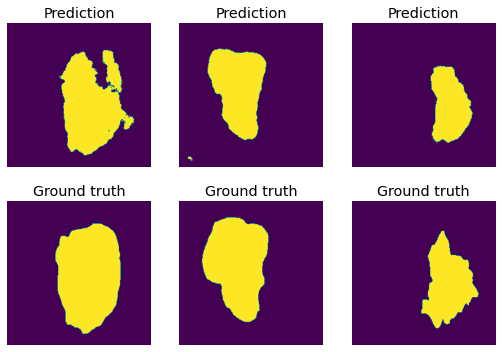

In [ ]:
x, y = next(iter(data_val))
y_hat = (model_focal(x.to(device))>0.5).float()
y_h = y_hat.detach().cpu().numpy()

plt.figure(figsize=(18, 6))
for i in range(3):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.title('Prediction')
    plt.imshow(y_h[i, 0])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.title('Ground truth')
    plt.imshow(y[i, 0])
plt.show();

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

**Structural Similarity Index (SSIM)**

In [ ]:
import torch

In [ ]:
def SSIM(y_pred, y_true, c1=1e-8, c2=1e-8):

  def covv(x, y):
    m_x = x.mean(dim=(2, 3))
    m_y = y.mean(dim=(2, 3))
    cov = ((x*y).mean(dim=(2, 3)) - m_x*m_y) / (256 * 256 - 1)
    return cov

  mean_pred = y_pred.mean(dim=(2, 3))
  mean_true = y_true.mean(dim=(2, 3))
  var_pred =  y_pred.var(dim=(2, 3))
  var_true =  y_true.var(dim=(2, 3))
  covar = covv(y_pred, y_true)

  ssim = (var_true + var_pred - 2 * covar) / (var_true + var_pred + c2)
  return 1 - ssim

In [ ]:
a = torch.randn(3, 1, 256, 256)
b = torch.randn(3, 1, 256, 256)
SSIM(a, b)

tensor([[ 5.9605e-08],
        [ 5.9605e-08],
        [-1.1921e-07]])

In [ ]:
model_ssim = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(model_ssim.parameters())
train_ssim, val_ssim  = train(model_ssim, optimaizer, SSIM, max_epochs, data_tr, data_val, device)

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

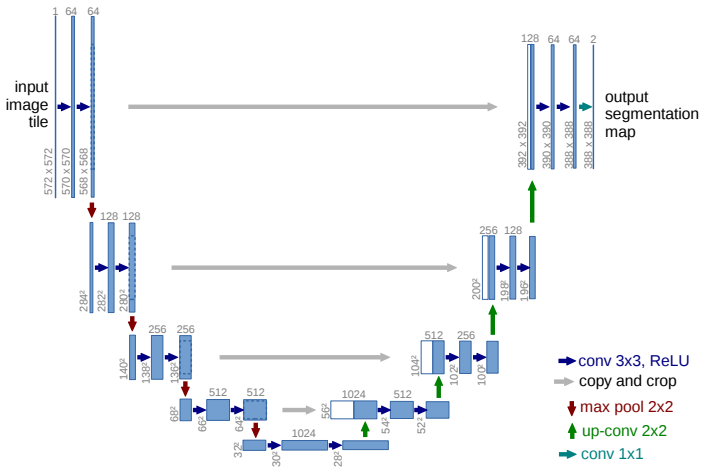

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64), 
            nn.ReLU())
        self.pool0 = nn.MaxPool2d((2, 2))    # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(), 
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.pool1 =  nn.MaxPool2d((2, 2))  # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(256), 
            nn.ReLU(), 
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(256), 
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(256), 
            nn.ReLU())
        self.pool2 = nn.MaxPool2d((2, 2))  # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(512), 
            nn.ReLU(), 
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(512),  
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(512), 
            nn.ReLU())
        self.pool3 = nn.MaxPool2d((2, 2))  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(1024),  
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(512), 
            nn.ReLU())

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='nearest') # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(512), 
            nn.ReLU(), 
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(512), 
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(256), 
            nn.ReLU())
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest') # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(256), 
            nn.ReLU(), 
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(256), 
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(128), 
            nn.ReLU())
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(128), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),  
            nn.ReLU())
        self.upsample3 = nn.Upsample(scale_factor=2, mode='nearest')  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU(), 
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),  
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=(1, 1), padding=0))

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(torch.cat((b, e3), dim=1)))
        d1 = self.dec_conv1(self.upsample1(torch.cat((d0, e2), dim=1)))
        d2 = self.dec_conv2(self.upsample2(torch.cat((d1, e1), dim=1)))
        d3 = self.dec_conv3(self.upsample3(torch.cat((d2, e0), dim=1))) # no activation
        return d3

In [ ]:
unet_model = UNet().to(device)

In [ ]:
x, y = next(iter(data_tr))
x = x.to(device)
y = y.to(device)
unet_model(x).shape

torch.Size([3, 1, 256, 256])

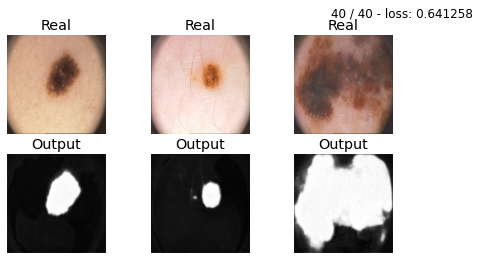

In [ ]:
unet_train, unet_val = train(unet_model, torch.optim.Adam(unet_model.parameters(), lr=0.00001), bce_loss, 40, data_tr, data_val, device)

In [ ]:
print('IOU score: %.3f' %(score_model(unet_model, iou_pytorch, data_val)))

IOU score: 0.719


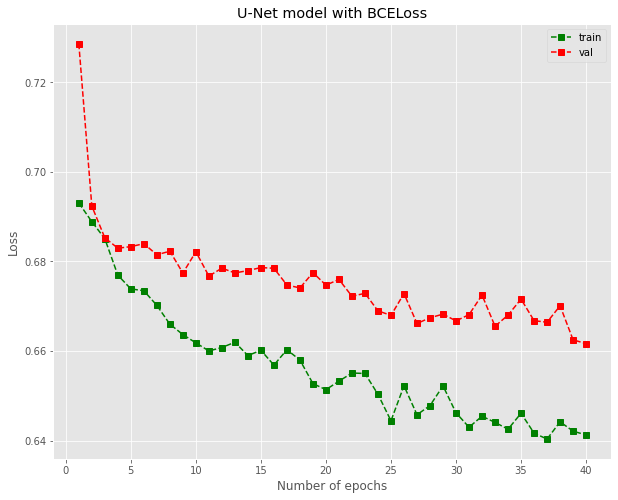

In [ ]:
plt.style.use('ggplot')

epochs = [*range(1,  max_epochs + 1)]
plt.figure(figsize=(10, 8))
plt.plot(epochs, unet_train, 's--g', label='train')
plt.plot(epochs, unet_val, 's--r', label='val')
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('U-Net model with BCELoss')
None

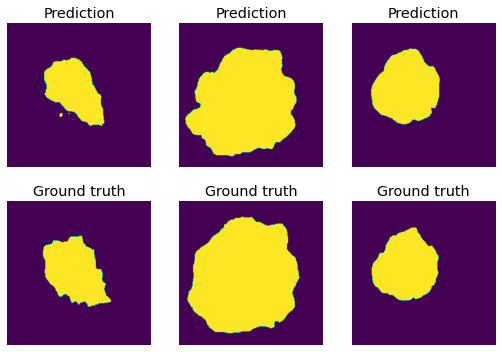

In [ ]:
x, y = next(iter(data_val))
y_hat = (unet_model(x.to(device)) > 0.5).float()
y_h = y_hat.detach().cpu().numpy()

plt.figure(figsize=(18, 6))
for i in range(3):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.title('Prediction')
    plt.imshow(y_h[i, 0])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.title('Ground truth')
    plt.imshow(y[i, 0])
plt.show();

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),  
            nn.ReLU())
        self.pool0 = nn.Conv2d(64, 64, kernel_size=(2, 2), stride=2)# 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(128), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.pool1 = nn.Conv2d(128, 128, kernel_size=(2, 2), stride=2) # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(256), 
            nn.ReLU(), 
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(256),  
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(256), 
            nn.ReLU())
        self.pool2 = nn.Conv2d(256, 256, kernel_size=(2, 2), stride=2)  # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(512),  
            nn.ReLU(), 
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(512), 
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.pool3 = nn.Conv2d(512, 512, kernel_size=(2, 2), stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU())

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(512), 
            nn.ReLU(), 
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(256), 
            nn.ReLU())
        
        self.upsample1 = nn.ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(256),  
            nn.ReLU(), 
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(256), 
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(128), 
            nn.ReLU())
        
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),  
            nn.ReLU(), 
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU())
        
        self.upsample3 = nn.ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU(), 
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=(1, 1), padding=0))

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(torch.cat((b, e3), dim=1)))
        d1 = self.dec_conv1(self.upsample1(torch.cat((d0, e2), dim=1)))
        d2 = self.dec_conv2(self.upsample2(torch.cat((d1, e1), dim=1)))
        d3 = self.dec_conv3(self.upsample3(torch.cat((d2, e0), dim=1))) # no activation
        return d3

In [ ]:
unet2_model = UNet2().to(device)

In [ ]:
x, _ = next(iter(data_tr))
unet2_model(x.to(device)).shape


torch.Size([3, 1, 256, 256])

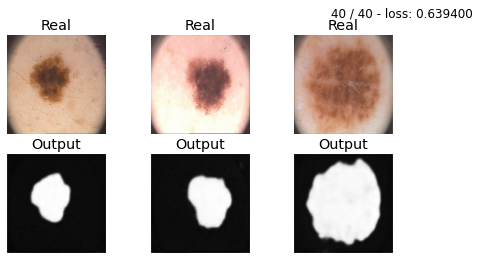

In [ ]:
unet2_train, unet2_val = train(unet2_model, torch.optim.Adam(unet2_model.parameters(), lr=0.00001), bce_loss, 40, data_tr, data_val, device)

In [ ]:
print('IOU score: %.3f' %(score_model(unet2_model, iou_pytorch, data_val)))

IOU score: 0.752


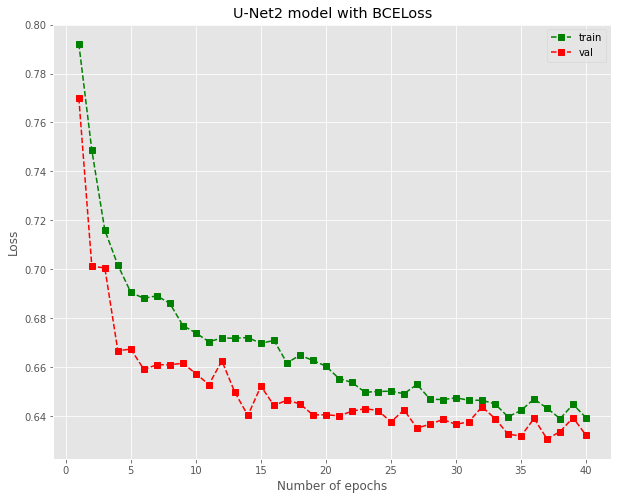

In [ ]:
plt.style.use('ggplot')

epochs = [*range(1,  max_epochs + 1)]
plt.figure(figsize=(10, 8))
plt.plot(epochs, unet2_train, 's--g', label='train')
plt.plot(epochs, unet2_val, 's--r', label='val')
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('U-Net2 model with BCELoss')
None

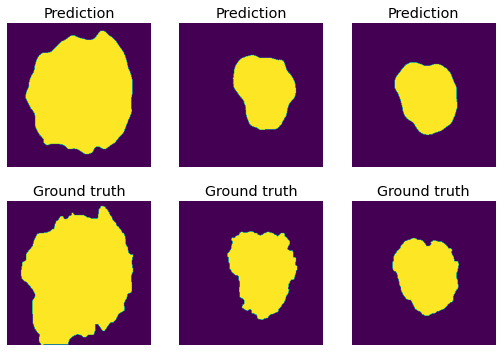

In [ ]:
x, y = next(iter(data_val))
y_hat = (unet2_model(x.to(device)) > 0.5).float()
y_h = y_hat.detach().cpu().numpy()

plt.figure(figsize=(18, 6))
for i in range(3):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.title('Prediction')
    plt.imshow(y_h[i, 0])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.title('Ground truth')
    plt.imshow(y[i, 0])
plt.show();

Сделайте вывод какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

# **Отчет о проделанной работе**

1. сраним на модели SegNet раличные лосы (будем сравнивать модель при одинаковых параметрах: n_epochs = 40, lr = 0.00001)

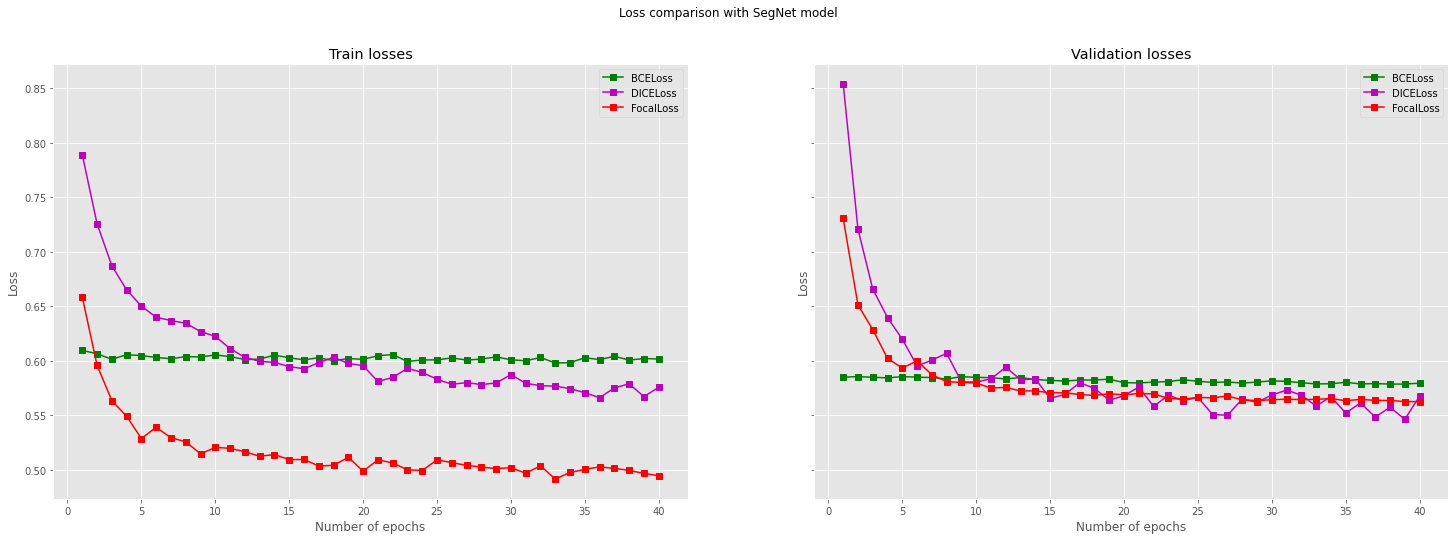

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25, 8))
ax1.plot(epochs, train_bce, 's-g', label='BCELoss')
ax1.plot(epochs, train_dice, 's-m', label='DICELoss')
ax1.plot(epochs, train_focal, 's-r', label='FocalLoss')
ax1.legend()
ax1.set_xlabel('Number of epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Train losses')

ax2.plot(epochs, val_bce, 's-g', label='BCELoss')
ax2.plot(epochs, val_dice, 's-m', label='DICELoss')
ax2.plot(epochs, val_focal, 's-r', label='FocalLoss')
ax2.legend()
ax2.set_xlabel('Number of epochs')
ax2.set_title('Validation losses')
ax2.set_ylabel('Loss')
fig.suptitle('Loss comparison with SegNet model')
None

Теперь давайте сравним качество моделей непосрественно посмотрев на результаты сегментации 

In [ ]:
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),batch_size=6, shuffle=True)
x, Y_TRUE = next(iter(data_val))

Y_BCE = (model(x.to(device)) > 0.5).float().detach().cpu().numpy()
Y_DICE = (model_dice(x.to(device)) > 0.5).float().detach().cpu().numpy()
Y_FOCAL = (model_focal(x.to(device)) > 0.5).float().detach().cpu().numpy()

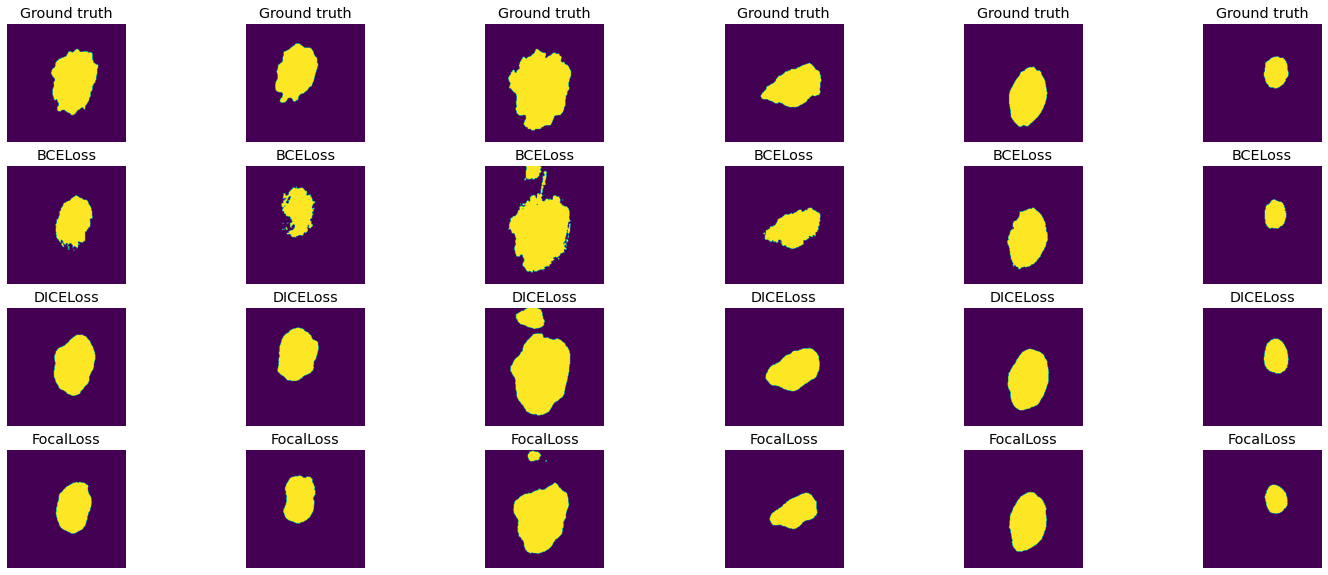

In [ ]:
plt.figure(figsize=(25, 10))
for i in range(6):
    plt.subplot(4, 6, i+1)
    plt.axis("off")
    plt.title('Ground truth')
    plt.imshow(Y_TRUE[i, 0])

    plt.subplot(4, 6, i+7)
    plt.axis("off")
    plt.title('BCELoss')
    plt.imshow(Y_BCE[i, 0])

    plt.subplot(4, 6, i+13)
    plt.axis("off")
    plt.title('DICELoss')
    plt.imshow(Y_DICE[i, 0])

    plt.subplot(4, 6, i+19)
    plt.axis("off")
    plt.title('FocalLoss')
    plt.imshow(Y_FOCAL[i, 0])
plt.show()

Также для сравнения дадим показатели метрики IOU по трем лоссам

In [ ]:
iou_bce = score_model(model, iou_pytorch, data_val)
iou_dice = score_model(model_dice, iou_pytorch, data_val)
iou_focal = score_model(model_focal, iou_pytorch, data_val)
print('IOU of BCELoss: %.3f   |   IOU of DICELoss: %.3f |  IOU of FocalLoss: %.3f' %(iou_bce, iou_dice, iou_focal))

IOU of BCELoss: 0.656   |   IOU of DICELoss: 0.680 |  IOU of FocalLoss: 0.578


Делая вывод по функциям потерь, можно сказать, что самое высокое каество при прочих равных показал DICELoss. Это качество можно заметить как на колличестве лосса на валидационной выборке, так по метрике IOU. Что касается других функций потерь, то стоит отметить, что FocalLoss демонстрирует силное переобучение модели, что негативно сказывается на качестве предсказаний. Таким образов, в данном разделе лучшей моделью при заданных параметрах является SegNet с DICELoss.


2. Теперь сравним результаты трех различных моделей (SegNet, U-Net и U-Net2) при использовании параметров 
n_epochs = 40, lr = 0.001

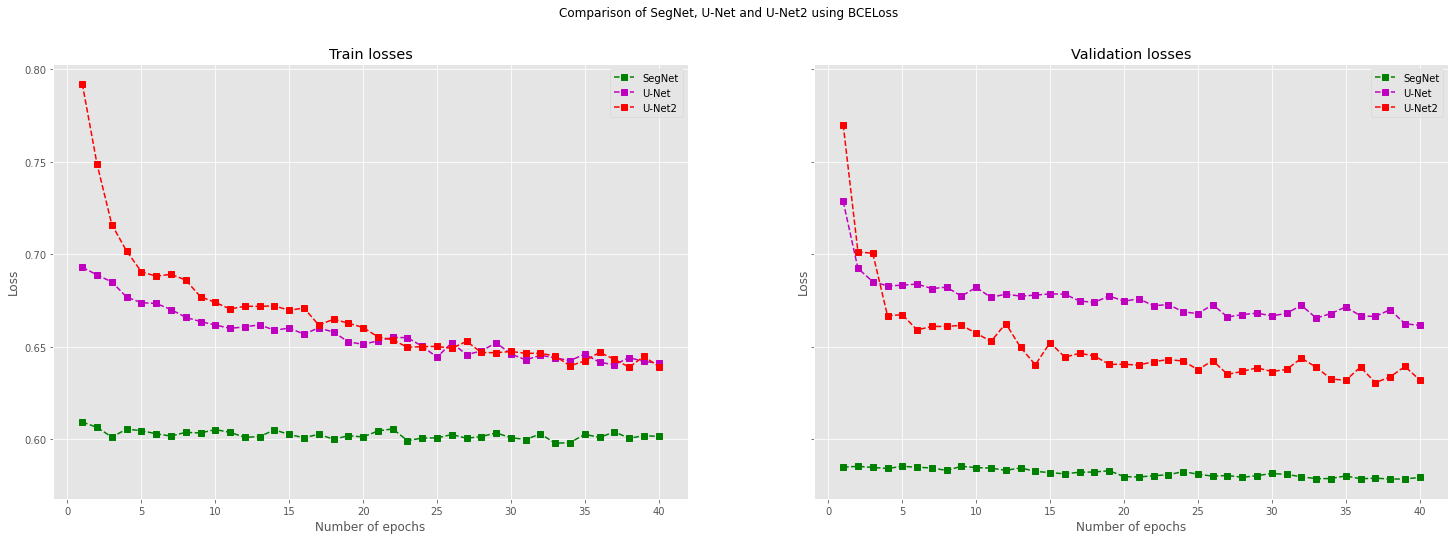

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25, 8))
ax1.plot(epochs, train_bce, 's--g', label='SegNet')
ax1.plot(epochs, unet_train, 's--m', label='U-Net')
ax1.plot(epochs, unet2_train, 's--r', label='U-Net2')
ax1.legend()
ax1.set_xlabel('Number of epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Train losses')

ax2.plot(epochs, val_bce, 's--g', label='SegNet')
ax2.plot(epochs, unet_val, 's--m', label='U-Net')
ax2.plot(epochs, unet2_val, 's--r', label='U-Net2')
ax2.legend()
ax2.set_xlabel('Number of epochs')
ax2.set_title('Validation losses')
ax2.set_ylabel('Loss')
fig.suptitle('Comparison of SegNet, U-Net and U-Net2 using BCELoss')
None

In [ ]:
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),batch_size=6, shuffle=True)
x, Y_true = next(iter(data_val))

Y_bce = (model(x.to(device)) > 0.5).float().detach().cpu().numpy()
Y_unet = (unet_model(x.to(device)) > 0.5).float().detach().cpu().numpy()
Y_unet2 = (unet2_model(x.to(device)) > 0.5).float().detach().cpu().numpy()

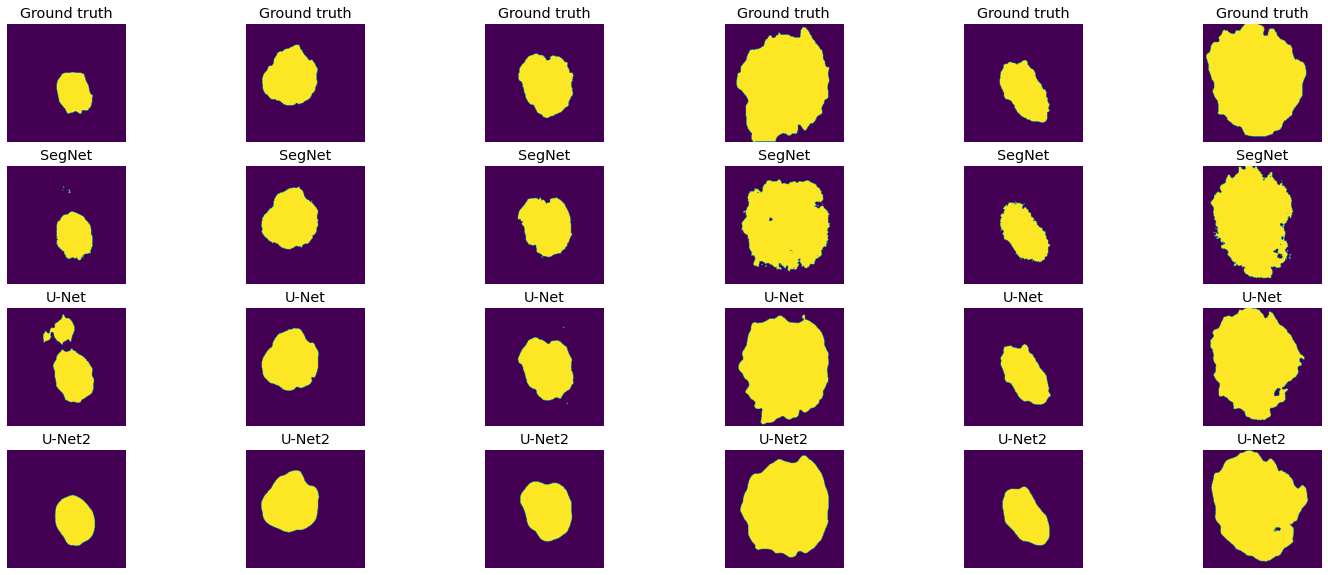

In [ ]:
plt.figure(figsize=(25, 10))
for i in range(6):
    plt.subplot(4, 6, i+1)
    plt.axis("off")
    plt.title('Ground truth')
    plt.imshow(Y_true[i, 0])

    plt.subplot(4, 6, i+7)
    plt.axis("off")
    plt.title('SegNet')
    plt.imshow(Y_bce[i, 0])

    plt.subplot(4, 6, i+13)
    plt.axis("off")
    plt.title('U-Net')
    plt.imshow(Y_unet[i, 0])

    plt.subplot(4, 6, i+19)
    plt.axis("off")
    plt.title('U-Net2')
    plt.imshow(Y_unet2[i, 0])
plt.show()

In [ ]:
iou_bce = score_model(model, iou_pytorch, data_val)
iou_dice = score_model(unet_model, iou_pytorch, data_val)
iou_focal = score_model(unet2_model, iou_pytorch, data_val)
print('IOU of SegNet: %.3f   |   IOU of U-Net: %.3f |  IOU of U-Net2: %.3f' %(iou_bce, iou_dice, iou_focal))

IOU of SegNet: 0.637   |   IOU of U-Net: 0.700 |  IOU of U-Net2: 0.752


Сравнив три различные модели, можно сделать вывод, что наиболее качественной является U-Net2. Эта модель дает наиболее качетсвенные предсказания и обладает самой высокой метрикой IOU=0.752. Что любопытно, так это то, что наиболее низкий лосс показывает модель SegNet, хотя она же дает и худшее качество из всех трех моделей.

Можно по пробовать дообучить U-Net2 на DICELoss и постараться получить более высокое качество.

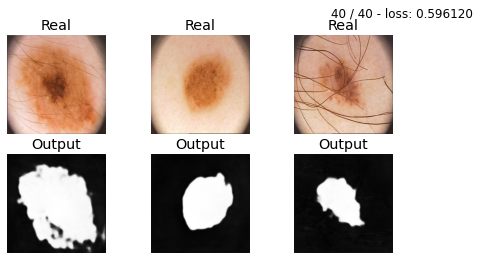

In [ ]:
unet2_train, unet2_val = train(unet2_model, torch.optim.Adam(unet2_model.parameters(), lr=0.00001), dice_loss, 40, data_tr, data_val, device)

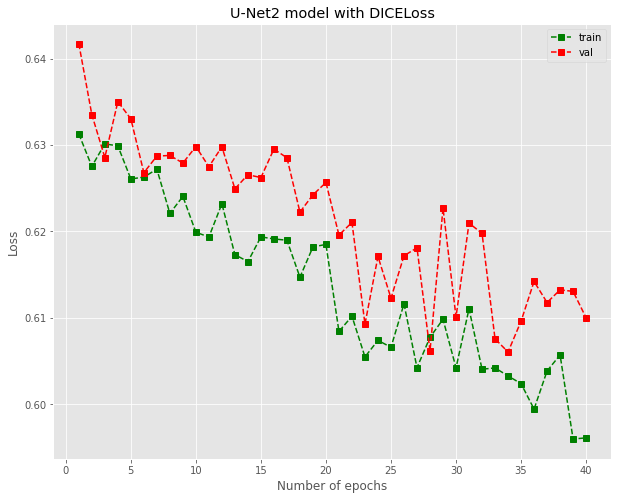

In [ ]:
plt.style.use('ggplot')

epochs = [*range(1,  max_epochs + 1)]
plt.figure(figsize=(10, 8))
plt.plot(epochs, unet2_train, 's--g', label='train')
plt.plot(epochs, unet2_val, 's--r', label='val')
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('U-Net2 model with DICELoss')
None

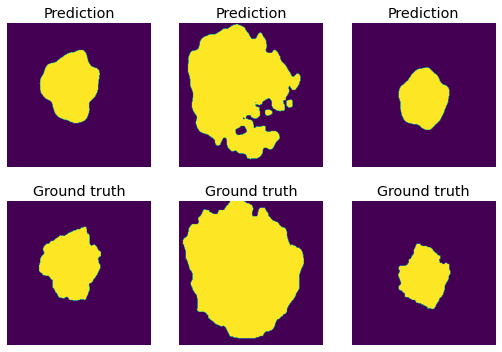

In [ ]:
x, y = next(iter(data_val))
y_hat = (unet2_model(x.to(device)) > 0.5).float()
y_h = y_hat.detach().cpu().numpy()

plt.figure(figsize=(18, 6))
for i in range(3):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.title('Prediction')
    plt.imshow(y_h[i, 0])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.title('Ground truth')
    plt.imshow(y[i, 0])
plt.show();

In [ ]:
print('IOU score: %.3f' %(score_model(unet2_model, iou_pytorch, data_val)))

IOU score: 0.802


Исходя из IOU можно сказать, что U-Net2 с DICELoss - это лучшая модель. 